In [1]:
%matplotlib inline
import openpathsampling as paths
import numpy as np
from toy_plot_helpers import ToyPlot

In [2]:
paths.base.StorableObject.observe_objects = True

In [3]:
import openpathsampling.toy_dynamics as toys
plot = ToyPlot()
pes = (
    toys.toy_pes.OuterWalls([1.0, 1.0], [0.0, 0.0]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, 0.5]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +
    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])
)

plot.contour_range = np.arange(-1.5, 1.0, 0.1)

topology=paths.ToyTopology(
    n_spatial = 2,
    masses =[1.0, 1.0],
    pes = pes
)

template = paths.Snapshot(
    coordinates=np.array([[-0.5, -0.5]]), 
    velocities=np.array([[0.0,0.0]]),
    potential_energy = 0.0, # Important to set energies dimensionless otherwise kcal/mol is default
    kinetic_energy = 0.0,
    topology=topology
)

integ = toys.toy_integrators.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5)

options={
    'integ' : integ,
    'n_frames_max' : 5000,
    'nsteps_per_frame' : 10
}

toy_eng = toys.toy_engine.ToyEngine(
    options=options,
    template=template
)
toy_eng.initialized = True

toy_eng.current_snapshot = template
paths.PathMover.engine = toy_eng

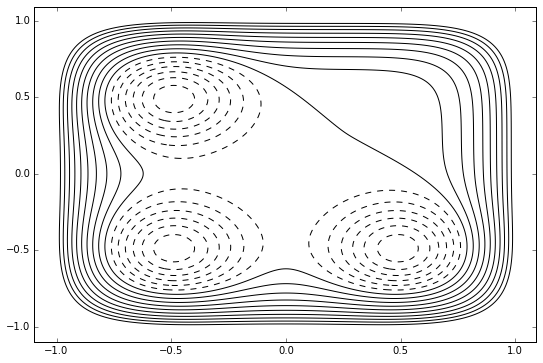

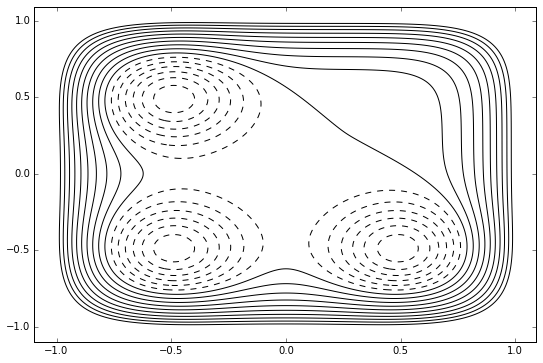

In [4]:
plot.add_pes(pes)
plot.plot()

In [5]:
def xval(snapshot):
    return snapshot.xyz[0][0]

def xprime(snapshot):
    # this only exists until we set up the ability for the order parameter to decrease
    return -snapshot.xyz[0][0]

def yval(snapshot):
    return snapshot.xyz[0][1]
    
opX = paths.CV_Function(name="opX", fcn=xval)
opY = paths.CV_Function(name="opY", fcn=yval)
opXprime = paths.CV_Function(name="opXprime", fcn=xprime)

In [6]:
x_under_min = paths.CVRangeVolume(opX, float("-inf"), -0.3)
x_over_max = paths.CVRangeVolume(opX, 0.3, float("inf")) 
y_under_min = paths.CVRangeVolume(opY, float("-inf"), -0.3)
y_over_max = paths.CVRangeVolume(opY, 0.3, float("inf")) 

stateA = x_under_min & y_under_min
stateB = x_over_max & y_under_min
stateC = x_under_min & y_over_max

In [7]:
#plot.add_states([stateA, stateB, stateC])
#plot.plot()

In [8]:
interfacesAB = paths.VolumeFactory.CVRangeVolumeSet(opX, float("-inf"), [-0.3, -0.2, -0.1, 0.0])
interfacesAC = paths.VolumeFactory.CVRangeVolumeSet(opY, float("-inf"), [-0.3, -0.2, -0.1, 0.0])
interfacesBA = paths.VolumeFactory.CVRangeVolumeSet(opXprime, float("-inf"), [-0.3, -0.2, -0.1, 0.0])

In [9]:
retisAB = paths.RETISTransition(stateA, stateB, interfacesAB, orderparameter=opX, name="A->B")
retisAC = paths.RETISTransition(stateA, stateC, interfacesAC, orderparameter=opY, name="A->C")
retisBA = paths.RETISTransition(stateB, stateA, interfacesBA, orderparameter=opXprime, name="B->A")

In [10]:
mistis = paths.MISTISNetwork([retisAB, retisAC, retisBA])

In [11]:
mistis.all_ensembles

In [12]:
paths.base.StorableObject.count_weaks()

{'CollectiveVariable': 3,
 'Configuration': 1,
 'DynamicsEngine': 1,
 'Ensemble': 663,
 'Momentum': 1,
 'PathMover': 285,
 'ShootingPointSelector': 10,
 'Snapshot': 2,
 'Topology': 1,
 'ToyIntegrator': 1,
 'Toy_PES': 7,
 'Transition': 9,
 'TransitionNetwork': 1,
 'Volume': 88}

In [13]:
mistis.sampling_transitions

In [14]:
mistis.transitions

{(<openpathsampling.volume.IntersectionVolume at 0x10cef6150>,
  <openpathsampling.volume.IntersectionVolume at 0x10cef61d0>): <openpathsampling.analysis.tis_analysis.RETISTransition at 0x10dac1c90>,
 (<openpathsampling.volume.IntersectionVolume at 0x10cef61d0>,
  <openpathsampling.volume.IntersectionVolume at 0x10cef60d0>): <openpathsampling.analysis.tis_analysis.RETISTransition at 0x10daa9690>,
 (<openpathsampling.volume.IntersectionVolume at 0x10cef61d0>,
  <openpathsampling.volume.IntersectionVolume at 0x10cef6150>): <openpathsampling.analysis.tis_analysis.RETISTransition at 0x10da839d0>}

In [15]:
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [16]:
# the other option might be to turn this into a class FullBootstrap, but this function seems to work for now
# TODO: move this function into openpathsampling (maybe have a module bootstrap_interfaces?)
import sys
def full_bootstrap(transition, snapshot, engine, extra_interfaces=[], forbidden_states=[], storage=None):
    interface0 = transition.interfaces[0]
    ensemble0 = transition.ensembles[0]
    state = transition.stateA
    first_traj_ensemble = paths.SequentialEnsemble([
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state)),
        paths.AllInXEnsemble(state),
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state) & paths.AllInXEnsemble(interface0)),
        paths.OptionalEnsemble(paths.AllInXEnsemble(interface0)),
        paths.AllOutXEnsemble(interface0),
        paths.OptionalEnsemble(paths.AllOutXEnsemble(state)),
        paths.SingleFrameEnsemble(paths.AllInXEnsemble(state))
    ]) & paths.AllOutXEnsemble(paths.join_volumes(forbidden_states))
    #print first_traj_ensemble #DEBUG
    has_AA_path = False
    while not has_AA_path:
        engine.current_snapshot = snapshot.copy()
        engine.snapshot = snapshot.copy()
        print "Building first trajectory"
        sys.stdout.flush()
        first_traj = engine.generate(engine.current_snapshot, [first_traj_ensemble.can_append])
        print "Selecting segment"
        sys.stdout.flush()
        subtraj = ensemble0.split(first_traj)[0]
        # check that this is A->A as well
        has_AA_path = state(subtraj[-1]) and state(subtraj[0])
        
    extra_ensembles = [
        paths.TISEnsemble(transition.stateA, transition.stateB, iface, transition.orderparameter)
        for iface in extra_interfaces
    ]
    extra_shooters = [paths.OneWayShootingMover(paths.UniformSelector(), ens) for ens in extra_ensembles]
    print "Sampling " + str(len(transition.ensembles+extra_ensembles)) + " ensembles."
    bootstrap = paths.Bootstrapping(
        storage=storage,
        ensembles=transition.ensembles+extra_ensembles,
        movers=transition.movers['shooting']+extra_shooters,
        trajectory=subtraj
    )
    print "Beginning bootstrapping"
    while len(bootstrap.globalstate) < len(transition.ensembles+extra_ensembles):
        bootstrap.run(20)
    return bootstrap.globalstate


In [17]:
paths.base.StorableObject.count_weaks()

{'CollectiveVariable': 3,
 'Configuration': 1,
 'DynamicsEngine': 1,
 'Ensemble': 663,
 'Momentum': 1,
 'PathMover': 285,
 'ShootingPointSelector': 10,
 'Snapshot': 2,
 'Topology': 1,
 'ToyIntegrator': 1,
 'Toy_PES': 7,
 'Transition': 9,
 'TransitionNetwork': 1,
 'Volume': 88}

In [18]:
snapA = paths.Snapshot(
    coordinates=[[-0.5, -0.5]],
    velocities=[[0.5, 0.0]]
)
init_AB = full_bootstrap(retisAB, snapA, toy_eng, forbidden_states=[stateC])

DONE! Completed Bootstrapping cycle step 165 in ensemble 4/4 .



In [19]:
paths.base.StorableObject.count_weaks()

{'CollectiveVariable': 3,
 'Configuration': 6285,
 'Details': 126,
 'DynamicsEngine': 1,
 'Ensemble': 663,
 'Momentum': 6285,
 'PathMover': 288,
 'Sample': 127,
 'SampleSet': 1,
 'ShootingPoint': 246,
 'ShootingPointSelector': 10,
 'Snapshot': 12826,
 'Topology': 1,
 'ToyIntegrator': 1,
 'Toy_PES': 7,
 'Trajectory': 124,
 'Transition': 9,
 'TransitionNetwork': 1,
 'Volume': 88}

In [20]:
snapA = paths.Snapshot(
    coordinates=[[-0.5, -0.5]],
    velocities=[[0.0, 0.5]]
)
init_AC = full_bootstrap(retisAC, snapA, toy_eng, forbidden_states=[stateB])

DONE! Completed Bootstrapping cycle step 16 in ensemble 4/4 .



In [21]:
snapB = paths.Snapshot(
    coordinates=[[0.5, -0.5]],
    velocities=[[-0.5, 0.0]]
)
init_BA = full_bootstrap(retisBA, snapB, toy_eng, forbidden_states=[stateC])

DONE! Completed Bootstrapping cycle step 102 in ensemble 4/4 .



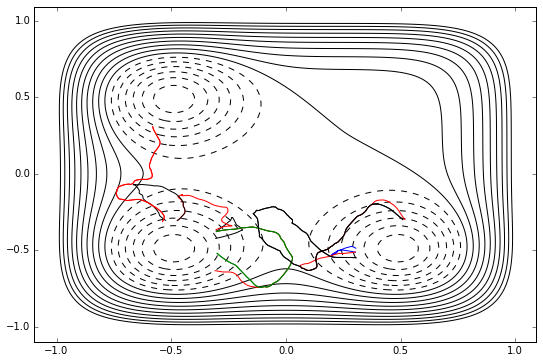

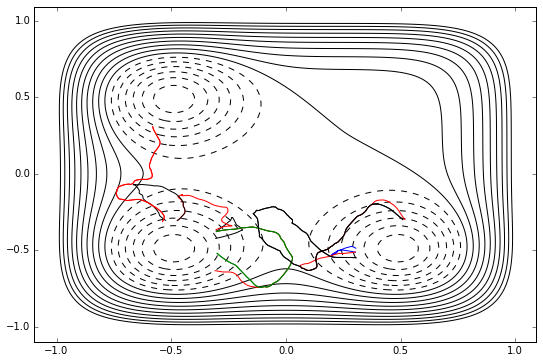

In [22]:
plot.plot([s.trajectory for s in list(init_AB)+list(init_AC)+list(init_BA)])

In [23]:
# TODO: it would be really nice if all of this could be handled somewhat automatically
samples = []
trans2trajs = {retisAB : init_AB, retisAC : init_AC, retisBA : init_BA}
for trans in trans2trajs.keys():
    new_trans = mistis.transition_to_sampling[trans]
    for i in range(len(new_trans.ensembles)):
        samples.append(paths.Sample(
                trajectory=trans2trajs[trans][i].trajectory,
                ensemble=new_trans.ensembles[i],
                replica=len(samples)
        ))
sset = paths.SampleSet(samples)
sset.sanity_check()

outer_sset = paths.SampleSet([init.samples[-1] for init in [init_AB, init_BA]])
outer_sample = paths.Sample(
    replica=len(sset),
    trajectory=init_AB.samples[-1].trajectory,
    ensemble=mistis.ms_outers[0]
)
sset = sset.apply_samples([outer_sample])
sset.sanity_check()

minus_samples = []
for minus in mistis.minus_ensembles:
    for partial_traj in [s.trajectory for s in sset]:
        if minus._segment_ensemble(partial_traj):
            break
    #print minus._segment_ensemble(partial_traj)
    good_sample = False
    while not good_sample:
        samp = minus.populate_minus_ensemble(
            partial_traj=partial_traj,
            minus_replica_id=-mistis.minus_ensembles.index(minus)-1,
            engine=toy_eng
        )
        good_sample = samp.ensemble(samp.trajectory)
    minus_samples.append(samp)

sset = sset.apply_samples(minus_samples)
sset.sanity_check()

In [24]:
#logging.config.fileConfig("debug_logging.conf", disable_existing_loggers=False)
storage = paths.storage.Storage("mistis.nc", "w", template=template)

In [28]:
storage.set_caching_mode('lowmemory')

In [31]:
paths.base.StorableObject.count_weaks()

{'CollectiveVariable': 3,
 'Configuration': 4256,
 'Details': 217,
 'DynamicsEngine': 1,
 'Ensemble': 663,
 'Momentum': 4256,
 'PathMover': 294,
 'Sample': 233,
 'SampleSet': 5,
 'ShootingPoint': 416,
 'ShootingPointSelector': 10,
 'Snapshot': 8941,
 'Topology': 1,
 'ToyIntegrator': 1,
 'Toy_PES': 7,
 'Trajectory': 213,
 'Transition': 9,
 'TransitionNetwork': 1,
 'Volume': 88}

In [30]:
storage.save(mistis)
storage.sync()

In [32]:
mistis_calc = paths.PathSampling(
    storage=storage,
    engine=toy_eng,
    move_scheme=mistis.default_schemes(),
    globalstate=sset
)
mistis_calc.save_frequency = 100

In [33]:
import logging.config
logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

mistis_calc.run(20)

DONE! Completed 20 Monte Carlo cycles.



In [34]:
import gc

In [44]:
gc.collect()

0

In [45]:
paths.base.StorableObject.count_weaks()

{'CollectiveVariable': 3,
 'Configuration': 2458,
 'Details': 217,
 'DynamicsEngine': 1,
 'Ensemble': 663,
 'MCStep': 10,
 'Momentum': 2458,
 'PathMoveChange': 46,
 'PathMover': 295,
 'PathSimulator': 1,
 'Sample': 265,
 'SampleSet': 17,
 'ShootingPoint': 416,
 'ShootingPointSelector': 10,
 'Snapshot': 5547,
 'Topology': 1,
 'ToyIntegrator': 1,
 'Toy_PES': 7,
 'Trajectory': 227,
 'Transition': 9,
 'TransitionNetwork': 1,
 'Volume': 88}

In [46]:
len(paths.base.StorableObject._weak_cache)

12741

In [ ]:
samp=storage.samples[1]
refs = gc.get_referrers(samp)

In [ ]:
samp.parent
samps = None

In [38]:
samps = [s for s in paths.base.StorableObject._weak_cache if s.base_cls_name == 'Sample']
samp = samps[50]
refs = gc.get_referrers(samp)
samps[50].parent = None
samps = None

In [40]:
samp._lazy

{<openpathsampling.base.DelayedLoader at 0x10a3deed0>: <openpathsampling.pathmover.Details at 0x10e396790>,
 <openpathsampling.base.DelayedLoader at 0x10a3def10>: <openpathsampling.pathmover.BackwardShootMover at 0x10d544650>,
 <openpathsampling.base.DelayedLoader at 0x10a3def50>: None}

In [144]:
ref = refs[6]
print type(ref), len(ref)
ref

<type 'dict'> 316


{'In': ['',
  u"get_ipython().magic(u'matplotlib inline')\nimport openpathsampling as paths\nimport numpy as np\nfrom toy_plot_helpers import ToyPlot",
  u'paths.base.StorableObject.observe_objects = True',
  u"import openpathsampling.toy_dynamics as toys\nplot = ToyPlot()\npes = (\n    toys.toy_pes.OuterWalls([1.0, 1.0], [0.0, 0.0]) +\n    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, 0.5]) +\n    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [-0.5, -0.5]) +\n    toys.toy_pes.Gaussian(-0.7, [12.0, 12.0], [0.5, -0.5])\n)\n\nplot.contour_range = np.arange(-1.5, 1.0, 0.1)\n\ntopology=paths.ToyTopology(\n    n_spatial = 2,\n    masses =[1.0, 1.0],\n    pes = pes\n)\n\ntemplate = paths.Snapshot(\n    coordinates=np.array([[-0.5, -0.5]]), \n    velocities=np.array([[0.0,0.0]]),\n    potential_energy = 0.0, # Important to set energies dimensionless otherwise kcal/mol is default\n    kinetic_energy = 0.0,\n    topology=topology\n)\n\ninteg = toys.toy_integrators.LangevinBAOABIntegrator(dt=0.02

In [ ]:
samp_idx = None

In [ ]:
samp_idx = {samp : idx for idx, samp in enumerate(samps)}
samp_idx[None] = None

In [ ]:
[(samp_idx[samp], samp_idx[samp.parent], storage.idx(samp)) for samp in samps]

In [21]:
_ipython_names = ['In', 'Out', 'exit', 'get_ipython', 'quit']
_complete = globals()
_global_name = {
    name : hex(id(obj))[2:] for name, obj in _complete.iteritems() 
        if not name.startswith('_')
        and not name in _ipython_names
}
_global_name_index = {
    value : key for key, value in _global_name.iteritems()
}
del _complete

In [22]:
def nrepr(obj):
    idx = hex(id(obj))[2:]
    if idx in _global_name_index:
        return _global_name_index[idx]
    elif obj in paths.base.StorableObject._weak_cache:
        return obj.base_cls_name + str(paths.base.StorableObject._weak_cache[obj])
    else:
        return None

In [ ]:
nrepr()